Imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_poisson_deviance
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor

Configuration

In [2]:
DATA_PATH_TRAIN = "DATA/learn.csv"
DATA_PATH_TEST = "DATA/test.csv"

FEAT_GLM = [
    "VehPowerGLM", "VehAgeGLM", "DrivAgeGLM", "BonusMalusGLM",
    "VehBrand", "VehGas", "DensityGLM", "Region", "AreaGLM"
]

FEAT_EBM = [
    "VehPower", "VehAge", "DrivAge", "BonusMalus",
    "VehBrand", "VehGas", "Density", "Region", "AreaGLM"
]

EBM_FEATURE_TYPES = [
    "continuous", "continuous", "continuous", "continuous",
    "nominal", "nominal", "continuous", "nominal", "continuous"
]

Helper Functions

In [3]:
def double_lift_fixed(y_m1, y_m2, y_act, weight=None, p_tile=10, model_names=("M1", "M2")):
    """Generates a Double Lift Chart comparing two models against actuals."""
    sns.set()
    df = pd.DataFrame({model_names[0]: y_m1, model_names[1]: y_m2, "actual": y_act})
    df["weight"] = weight if weight is not None else 1
    df["Ratio"] = df[model_names[0]] / df[model_names[1]]
    df = df.sort_values("Ratio")
    df["cum_w"] = df["weight"].cumsum()
    df["p_tile"] = pd.qcut(df["cum_w"], p_tile, labels=False, duplicates="drop") + 1
    
    agg = df.groupby("p_tile").agg({model_names[0]: "mean", model_names[1]: "mean", "actual": "mean"}).reset_index()
    melted = agg.melt("p_tile", var_name="Model", value_name="Value")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=melted, x="p_tile", y="Value", hue="Model", marker="o")
    plt.title("Double Lift Chart")
    plt.grid(True, alpha=0.3)
    return agg, df

In [4]:
def get_prediction_breakdown(ebm, X, feature_names=None):
    """
    Berechnet für jede Prediction die Beiträge aller Features/Terme.
    
    Returns:
        predictions: Array mit finalen Predictions
        breakdowns: Liste von Dictionaries mit Feature-Beiträgen pro Sample
    """
    if feature_names is None:
        feature_names = ebm.feature_names if hasattr(ebm, 'feature_names') else [f"Feature_{i}" for i in range(X.shape[1])]
    
    sample_scores = []
    breakdowns = []
    
    # X zu numpy array konvertieren falls DataFrame
    if isinstance(X, pd.DataFrame):
        X_array = X.values
    else:
        X_array = np.array(X)
    
    for sample_idx, sample in enumerate(X_array):
        # Start mit Intercept
        if isinstance(ebm.intercept_, (int, float, np.number)):
            intercept_val = float(ebm.intercept_)
        else:
            intercept_val = float(ebm.intercept_[0])
        
        score = intercept_val
        
        # Dictionary für dieses Sample
        breakdown = {
            'sample_idx': sample_idx,
            'intercept': intercept_val,
            'features': {}
        }
        
        # Durch alle Terme iterieren
        for term_idx, features in enumerate(ebm.term_features_):
            # Term-Name erstellen
            if len(features) == 1:
                term_name = feature_names[features[0]]
            else:
                term_name = " x ".join([feature_names[f] for f in features])
            
            # Tensor-Index für diesen Term aufbauen
            tensor_index = []
            feature_values = {}
            
            for feature_idx in features:
                feature_val = sample[feature_idx]
                feature_values[feature_names[feature_idx]] = feature_val
                
                # Hole die richtigen Bins für dieses Feature
                bin_levels = ebm.bins_[feature_idx]
                # Für Interaktionen: verwende die entsprechende Auflösung
                # Für main effects: immer bin_levels[0]
                if len(features) == 1:
                    bins = bin_levels[0]
                else:
                    # Bei Interaktionen: nutze die Auflösung basierend auf der Term-Länge
                    resolution_idx = min(len(bin_levels) - 1, len(features) - 1)
                    bins = bin_levels[resolution_idx]
                
                # Bin-Index bestimmen
                bin_idx = 0  # default für MISSING
                
                # Check ob Wert fehlt
                is_missing = False
                if feature_val is None:
                    is_missing = True
                elif isinstance(feature_val, float) and np.isnan(feature_val):
                    is_missing = True
                elif isinstance(feature_val, str) and feature_val.strip() == '':
                    is_missing = True
                
                if not is_missing:
                    if isinstance(bins, dict):
                        # Kategorisches Feature
                        # Konvertiere zu String und handle verschiedene Typen
                        if isinstance(feature_val, (int, np.integer)):
                            feature_val_str = str(int(feature_val))
                        elif isinstance(feature_val, (float, np.floating)):
                            # Prüfe ob es eigentlich ein Integer ist
                            if feature_val == int(feature_val):
                                feature_val_str = str(int(feature_val))
                            else:
                                feature_val_str = str(feature_val)
                        else:
                            feature_val_str = str(feature_val)
                        
                        if feature_val_str in bins:
                            bin_idx = bins[feature_val_str]
                        else:
                            # UNSEEN: letzter Index im Score-Array
                            bin_idx = len(bins) + 1  # +1 wegen MISSING bei Index 0
                    else:
                        # Kontinuierliches Feature
                        try:
                            feature_val_float = float(feature_val)
                            
                            # np.digitize gibt die Position an wo eingefügt werden würde
                            # bins = [10, 20, 30] und value = 15 → digitize = 1
                            # Aber wir brauchen: ≤10 → idx=1, 10-20 → idx=2, 20-30 → idx=3, >30 → idx=4
                            # idx 0 ist für MISSING reserviert
                            digit_idx = np.digitize(feature_val_float, bins, right=False)
                            bin_idx = digit_idx + 1  # +1 wegen MISSING bei Index 0
                            
                            # UNSEEN check: wenn größer als alle Bins
                            if bin_idx > len(bins) + 1:
                                bin_idx = len(bins) + 1
                                
                        except (ValueError, TypeError):
                            # Falls Konvertierung fehlschlägt → MISSING
                            bin_idx = 0
                else:
                    bin_idx = 0  # MISSING
                
                tensor_index.append(bin_idx)
            
            # Score-Beitrag für diesen Term
            try:
                local_score = ebm.term_scores_[term_idx][tuple(tensor_index)]
            except IndexError:
                # Fallback bei Index-Problemen
                print(f"Warning: Index {tuple(tensor_index)} out of bounds for term {term_name}")
                print(f"  Score shape: {ebm.term_scores_[term_idx].shape}")
                local_score = 0.0
            
            score += local_score
            
            # In Breakdown speichern
            breakdown['features'][term_name] = {
                'value': feature_values,
                'contribution': float(local_score),
                'bin_indices': tensor_index
            }
        
        breakdown['total_score'] = float(score)
        sample_scores.append(score)
        breakdowns.append(breakdown)
    
    predictions = np.array(sample_scores)
    
    # Für Regression mit Poisson/Log-Link: exp() anwenden
    if hasattr(ebm, 'link_') and ebm.link_ == 'log':
        predictions = np.exp(predictions)
    elif hasattr(ebm, 'objective') and 'poisson' in str(ebm.objective).lower():
        # Poisson Regression hat implizit log-link
        predictions = np.exp(predictions)
    # Für Klassifikation: Softmax anwenden
    elif hasattr(ebm, 'classes_'):
        from sklearn.utils.extmath import softmax
        if len(ebm.classes_) == 2:
            predictions = [[0, x] for x in predictions]
        predictions = softmax(predictions)
    
    return predictions, breakdowns


def breakdown_to_dataframe(breakdowns, wide_format=False):
    """
    Konvertiert Breakdowns in ein übersichtliches DataFrame.
    
    Parameters:
        wide_format: Wenn True, ein Feature pro Spalte; wenn False, long format
    """
    if wide_format:
        # Wide Format: Eine Zeile pro Sample, eine Spalte pro Feature
        records = []
        for bd in breakdowns:
            record = {
                'sample_idx': bd['sample_idx'],
                'intercept': bd['intercept'],
            }
            for feat_name, feat_info in bd['features'].items():
                record[f'{feat_name}_contribution'] = feat_info['contribution']
            record['total_score'] = bd['total_score']
            records.append(record)
        return pd.DataFrame(records)
    else:
        # Long Format: Eine Zeile pro Feature pro Sample
        records = []
        for bd in breakdowns:
            for feat_name, feat_info in bd['features'].items():
                records.append({
                    'sample_idx': bd['sample_idx'],
                    'feature': feat_name,
                    'feature_value': str(feat_info['value']),
                    'contribution': feat_info['contribution'],
                    'bin_indices': str(feat_info['bin_indices'])
                })
        return pd.DataFrame(records)

def validate_predictions(ebm, X, feature_names=None, tolerance=1e-6):
    """
    Validiert dass die manuell berechneten Predictions mit den EBM-Predictions übereinstimmen.
    """
    predictions, breakdowns = get_prediction_breakdown(ebm, X, feature_names)
    ebm_predictions = ebm.predict(X)
    
    diff = np.abs(predictions - ebm_predictions)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    
    print("=" * 80)
    print("VALIDIERUNG DER PREDICTIONS")
    print("=" * 80)
    print(f"Maximale Differenz: {max_diff:.10f}")
    print(f"Durchschnittliche Differenz: {mean_diff:.10f}")
    print(f"Toleranz: {tolerance:.10f}")
    
    if max_diff < tolerance:
        print("✓ VALIDIERUNG ERFOLGREICH - Predictions stimmen überein!")
    else:
        print("✗ WARNUNG - Predictions weichen ab!")
        print("\nErste 5 Vergleiche:")
        comparison = pd.DataFrame({
            'Manual': predictions[:5],
            'EBM': ebm_predictions[:5],
            'Diff': diff[:5]
        })
        print(comparison)
    
    return predictions, breakdowns, max_diff < tolerance

def export_breakdowns_to_excel(ebm, X, breakdowns, predictions, filename, feature_names=None):
    """
    Exportiert Breakdowns in eine Excel-Datei.
    
    WICHTIG: X, breakdowns und predictions müssen die gleiche Anzahl Samples haben!
    """
    # Validiere dass alle die gleiche Länge haben
    if len(X) != len(breakdowns) or len(X) != len(predictions):
        raise ValueError(
            f"Längen stimmen nicht überein: X={len(X)}, breakdowns={len(breakdowns)}, predictions={len(predictions)}"
        )
    
    # EBM Predictions holen
    ebm_predictions = ebm.predict(X)
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Wide format mit beiden Predictions
        df_wide = breakdown_to_dataframe(breakdowns, wide_format=True)
        df_wide['prediction_manual'] = predictions
        df_wide['prediction_ebm'] = ebm_predictions
        df_wide['prediction_diff'] = np.abs(predictions - ebm_predictions)
        df_wide.to_excel(writer, sheet_name='Breakdown Wide', index=False)
        
        # Long format ohne bin_indices
        df_long = breakdown_to_dataframe(breakdowns, wide_format=False)
        df_long = df_long.drop(columns=['bin_indices'])
        df_long.to_excel(writer, sheet_name='Breakdown Long', index=False)
    
    print(f"Breakdowns exportiert nach: {filename}")

In [5]:
def get_ebm_coefficients(ebm, feature_names=None):
    """
    Extrahiert alle Koeffizienten/Scores aus einem EBM-Modell.
    
    Returns:
        DataFrame mit allen Bins und ihren Scores für jedes Feature
    """
    if feature_names is None:
        feature_names = ebm.feature_names if hasattr(ebm, 'feature_names') else [f"Feature_{i}" for i in range(len(ebm.bins_))]
    
    all_coefficients = []
    
    for term_idx, features in enumerate(ebm.term_features_):
        # Term-Name
        if len(features) == 1:
            term_name = feature_names[features[0]]
            term_type = "main_effect"
        else:
            term_name = " x ".join([feature_names[f] for f in features])
            term_type = "interaction"
        
        # Scores für diesen Term
        scores = ebm.term_scores_[term_idx]
        
        if len(features) == 1:
            # Main Effect - einfacher zu verarbeiten
            feature_idx = features[0]
            bin_levels = ebm.bins_[feature_idx]
            bins = bin_levels[0]  # Erste Auflösung
            
            if isinstance(bins, dict):
                # Kategorisches Feature
                for category, bin_idx in bins.items():
                    score = scores[bin_idx]
                    all_coefficients.append({
                        'term': term_name,
                        'term_type': term_type,
                        'feature': feature_names[feature_idx],
                        'bin_value': str(category),
                        'bin_index': bin_idx,
                        'score': float(score)
                    })
                # Missing und Unseen
                all_coefficients.append({
                    'term': term_name,
                    'term_type': term_type,
                    'feature': feature_names[feature_idx],
                    'bin_value': 'MISSING',
                    'bin_index': 0,
                    'score': float(scores[0])
                })
                all_coefficients.append({
                    'term': term_name,
                    'term_type': term_type,
                    'feature': feature_names[feature_idx],
                    'bin_value': 'UNSEEN',
                    'bin_index': -1,
                    'score': float(scores[-1])
                })
            else:
                # Kontinuierliches Feature
                for bin_idx in range(len(scores)):
                    if bin_idx == 0:
                        bin_desc = "MISSING"
                    elif bin_idx == len(scores) - 1:
                        bin_desc = "UNSEEN"
                    elif bin_idx == 1:
                        bin_desc = f"≤ {bins[0]:.4g}"
                    elif bin_idx <= len(bins):
                        bin_desc = f"{bins[bin_idx-2]:.4g} - {bins[bin_idx-1]:.4g}"
                    else:
                        bin_desc = f"> {bins[-1]:.4g}"
                    
                    all_coefficients.append({
                        'term': term_name,
                        'term_type': term_type,
                        'feature': feature_names[feature_idx],
                        'bin_value': bin_desc,
                        'bin_index': bin_idx,
                        'score': float(scores[bin_idx])
                    })
        else:
            # Interaktion - jetzt alle Kombinationen extrahieren
            # scores ist hier ein mehrdimensionales Array
            bins_list = []
            for feat_idx in features:
                bin_levels = ebm.bins_[feat_idx]
                # Bei Interaktionen: nutze die Auflösung basierend auf der Term-Länge
                resolution_idx = min(len(bin_levels) - 1, len(features) - 1)
                bins_list.append(bin_levels[resolution_idx])
            
            # Flatten scores und iteriere durch alle Kombinationen
            scores_flat = scores.flatten()
            
            # Erstelle alle Bin-Kombinationen
            for idx in range(len(scores_flat)):
                # Berechne die Multi-Index-Position
                indices = np.unravel_index(idx, scores.shape)
                
                bin_desc_parts = []
                for dim, (feat_idx, bin_idx) in enumerate(zip(features, indices)):
                    bins = bins_list[dim]
                    feat_name = feature_names[feat_idx]
                    
                    if isinstance(bins, dict):
                        # Kategorisch
                        if bin_idx == 0:
                            bin_desc_parts.append(f"{feat_name}=MISSING")
                        elif bin_idx == len(bins) + 1:
                            bin_desc_parts.append(f"{feat_name}=UNSEEN")
                        else:
                            # Finde die Kategorie für diesen Index
                            category = [k for k, v in bins.items() if v == bin_idx]
                            if category:
                                bin_desc_parts.append(f"{feat_name}={category[0]}")
                            else:
                                bin_desc_parts.append(f"{feat_name}=BIN{bin_idx}")
                    else:
                        # Kontinuierlich
                        if bin_idx == 0:
                            bin_desc_parts.append(f"{feat_name}=MISSING")
                        elif bin_idx == len(bins) + 1:
                            bin_desc_parts.append(f"{feat_name}=UNSEEN")
                        elif bin_idx == 1:
                            bin_desc_parts.append(f"{feat_name}≤{bins[0]:.4g}")
                        elif bin_idx <= len(bins):
                            bin_desc_parts.append(f"{feat_name}∈[{bins[bin_idx-2]:.4g},{bins[bin_idx-1]:.4g})")
                        else:
                            bin_desc_parts.append(f"{feat_name}>{bins[-1]:.4g}")
                
                bin_value = " & ".join(bin_desc_parts)
                
                all_coefficients.append({
                    'term': term_name,
                    'term_type': term_type,
                    'feature': term_name,
                    'bin_value': bin_value,
                    'bin_index': f"{indices}",
                    'score': float(scores_flat[idx])
                })
    
    return pd.DataFrame(all_coefficients)


def print_feature_summary(ebm, feature_names=None, top_n=10):
    """
    Druckt eine übersichtliche Zusammenfassung der wichtigsten Features.
    """
    df_coef = get_ebm_coefficients(ebm, feature_names)
    
    print("=" * 80)
    print("EBM MODELL KOEFFIZIENTEN ÜBERSICHT")
    print("=" * 80)
    
    # Intercept
    intercept = ebm.intercept_[0] if hasattr(ebm.intercept_, '__len__') else ebm.intercept_
    print(f"\nIntercept: {intercept:.6f}")
    
    # Feature Importance (durchschnittlicher absoluter Beitrag)
    print("\n" + "=" * 80)
    print("FEATURE IMPORTANCE (Top {})".format(top_n))
    print("=" * 80)
    
    feature_importance = df_coef[df_coef['term_type'] == 'main_effect'].groupby('feature').agg({
        'score': lambda x: np.mean(np.abs(x))
    }).sort_values('score', ascending=False).head(top_n)
    
    for idx, (feature, row) in enumerate(feature_importance.iterrows(), 1):
        print(f"{idx:2d}. {feature:30s} | Avg |Score|: {row['score']:.6f}")
    
    # Interaktionen
    interactions = df_coef[df_coef['term_type'] == 'interaction'].groupby('term').agg({
        'score': lambda x: np.mean(np.abs(x))
    }).sort_values('score', ascending=False)
    
    if len(interactions) > 0:
        print("\n" + "=" * 80)
        print(f"INTERAKTIONEN (Top {min(5, len(interactions))})")
        print("=" * 80)
        for idx, (term, row) in enumerate(interactions.head(5).iterrows(), 1):
            print(f"{idx:2d}. {term:50s} | Avg |Score|: {row['score']:.6f}")
    
    # Detaillierte Koeffizienten pro Feature
    print("\n" + "=" * 80)
    print("DETAILLIERTE KOEFFIZIENTEN")
    print("=" * 80)
    
    for feature in feature_importance.index[:5]:  # Top 5 im Detail
        print(f"\n{feature}:")
        print("-" * 80)
        feature_coefs = df_coef[df_coef['feature'] == feature].sort_values('score', ascending=False)
        
        for _, row in feature_coefs.iterrows():
            if row['bin_value'] not in ['MISSING', 'UNSEEN'] or row['score'] != 0:
                print(f"  {row['bin_value']:40s} → Score: {row['score']:+.6f}")
    
    return df_coef


def export_coefficients_to_excel(ebm, filename, feature_names=None):
    """
    Exportiert alle Koeffizienten in eine Excel-Datei mit mehreren Sheets.
    """
    df_coef = get_ebm_coefficients(ebm, feature_names)
    
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Alle Koeffizienten
        df_coef.to_excel(writer, sheet_name='All Coefficients', index=False)
        
        # Feature Importance
        feature_importance = df_coef[df_coef['term_type'] == 'main_effect'].groupby('feature').agg({
            'score': [('mean_abs_score', lambda x: np.mean(np.abs(x))),
                     ('max_score', 'max'),
                     ('min_score', 'min')]
        }).round(6)
        feature_importance.columns = ['mean_abs_score', 'max_score', 'min_score']
        feature_importance = feature_importance.sort_values('mean_abs_score', ascending=False)
        feature_importance.to_excel(writer, sheet_name='Feature Importance')
        
        # Interaktionen separat
        interactions = df_coef[df_coef['term_type'] == 'interaction']
        if len(interactions) > 0:
            interactions.to_excel(writer, sheet_name='Interactions', index=False)
        
        # Jedes Feature auf eigenem Sheet (Top 10)
        top_features = feature_importance.head(10).index
        for feature in top_features:
            feature_df = df_coef[df_coef['feature'] == feature][['bin_value', 'score']].copy()
            # Excel-Sheet-Namen dürfen max 31 Zeichen haben
            sheet_name = feature[:31] if len(feature) <= 31 else feature[:28] + "..."
            feature_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"Koeffizienten exportiert nach: {filename}")

Data Loading & Preprocessing

In [6]:
train = pd.read_csv(DATA_PATH_TRAIN)
test = pd.read_csv(DATA_PATH_TEST)

train_expo, test_expo = train["Exposure"], test["Exposure"]
log_expo_train, log_expo_test = np.log(train_expo), np.log(test_expo)

y_train, y_test = train["ClaimNb"], test["ClaimNb"]
X_train_ebm, X_test_ebm = train[FEAT_EBM], test[FEAT_EBM]

GLM Base Model

In [7]:
formula1 = "ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + C(DrivAgeGLM) + BonusMalusGLM + C(VehBrand) + C(VehGas) + DensityGLM + C(Region) + C(AreaGLM)"
glm1 = sm.GLM.from_formula(formula1, data=train, family=sm.families.Poisson(), offset=log_expo_train).fit()

GLM Complex Model

In [8]:
formula3 = """ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + np.log(DrivAge) + I(DrivAge**3) + I(DrivAge**4) + 
              BonusMalusGLM * DrivAge + BonusMalusGLM * I(DrivAge**2) + C(VehBrand) + C(VehGas) + 
              DensityGLM + C(Region) + AreaGLM"""
glm3 = smf.glm(formula3, data=train, family=sm.families.Poisson(), offset=log_expo_train).fit()

EBM Models

In [9]:
ebm_std = ExplainableBoostingRegressor(feature_names=FEAT_EBM, feature_types=EBM_FEATURE_TYPES, objective="poisson_deviance", n_jobs=1)
ebm_std.fit(X_train_ebm, y_train, init_score=log_expo_train)

ebm_best = ExplainableBoostingRegressor(feature_names=FEAT_EBM, feature_types=EBM_FEATURE_TYPES, objective="poisson_deviance", interactions=1, n_jobs=1)
ebm_best.fit(X_train_ebm, y_train, init_score=log_expo_train)

ebm_best2 = ExplainableBoostingRegressor(feature_names=FEAT_EBM, feature_types=EBM_FEATURE_TYPES, objective="poisson_deviance", interactions=3, n_jobs=1)
ebm_best2.fit(X_train_ebm, y_train, init_score=log_expo_train)

,feature_names,"['VehPower', 'VehAge', ...]"
,feature_types,"['continuous', 'continuous', ...]"
,max_bins,1024
,max_interaction_bins,64
,interactions,3
,exclude,None
,validation_size,0.15
,outer_bags,14
,inner_bags,0
,learning_rate,0.04
,greedy_ratio,10.0


Evaluation

In [10]:
preds_dict = {
    "GLM_Base": glm1.predict(test, offset=log_expo_test),
    "GLM_Complex": glm3.predict(test, offset=log_expo_test),
    "EBM_Std": ebm_std.predict(X_test_ebm, init_score=log_expo_test),
    "EBM_Best": ebm_best.predict(X_test_ebm, init_score=log_expo_test),
    "EBM_Best2": ebm_best2.predict(X_test_ebm, init_score=log_expo_test)
}

for name, p in preds_dict.items():
    dev = mean_poisson_deviance(y_test, p)
    print(f"{name} Test Deviance: {dev:.6f}")

GLM_Base Test Deviance: 0.241479
GLM_Complex Test Deviance: 0.241022
EBM_Std Test Deviance: 0.235876
EBM_Best Test Deviance: 0.236550
EBM_Best2 Test Deviance: 0.236381


Visualization & Explainability

<!-- http://127.0.0.1:7001/2700489570496/ -->

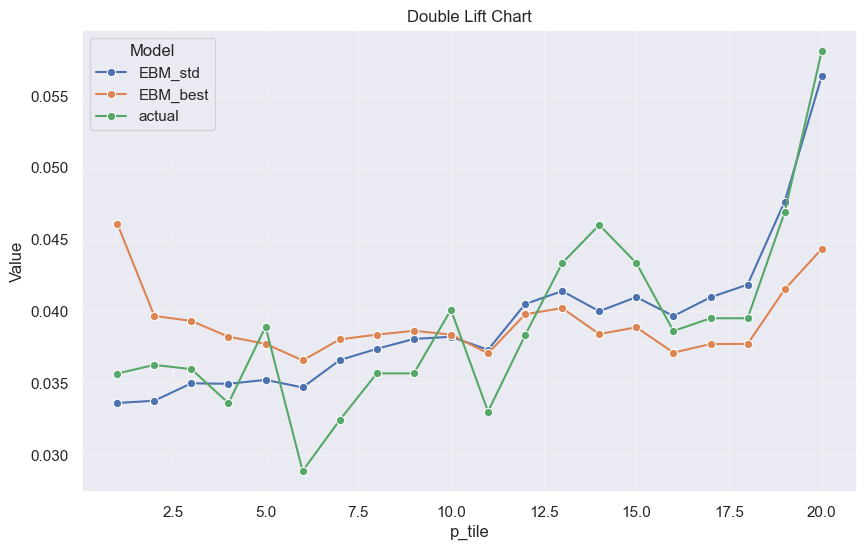

In [11]:
ebm_global = ebm_best2.explain_global()
show(ebm_global)

double_lift_fixed(preds_dict["EBM_Std"], preds_dict["EBM_Best2"], y_test, p_tile=20, model_names=("EBM_std", "EBM_best"))
plt.show()

In [12]:
# 1. Berechne Breakdowns für gewünschte Anzahl Samples
X_sample = test[FEAT_EBM].head(100)
predictions, breakdowns = get_prediction_breakdown(ebm_best, X_sample, feature_names=FEAT_EBM)

# Optional: Validierung auf subset
predictions_val, breakdowns_val, is_valid = validate_predictions(
    ebm_best, 
    X_sample.head(10), 
    feature_names=FEAT_EBM
)

# 2. Detaillierter Breakdown für die ersten 5 Samples
for sample_idx in range(min(5, len(breakdowns))):
    print(f"\n{'=' * 80}")
    print(f"DETAILLIERTER BREAKDOWN FÜR SAMPLE {sample_idx}")
    print(f"{'=' * 80}")
    print(f"Intercept: {breakdowns[sample_idx]['intercept']:.6f}")
    print("-" * 80)
    
    # Sortiere Features nach absolutem Beitrag
    features_sorted = sorted(
        breakdowns[sample_idx]['features'].items(), 
        key=lambda x: abs(x[1]['contribution']), 
        reverse=True
    )
    
    for feat_name, feat_info in features_sorted:
        print(f"{feat_name:30s}: {str(feat_info['value']):20s} → {feat_info['contribution']:+.6f}")
    
    print("-" * 80)
    print(f"Total Score (log-scale): {breakdowns[sample_idx]['total_score']:.6f}")
    print(f"Final Prediction (exp):  {predictions[sample_idx]:.10f}")

# 3. Test in Excel
export_breakdowns_to_excel(ebm_best, X_sample, breakdowns, predictions, 'ebm_breakdowns.xlsx', feature_names=FEAT_EBM)

VALIDIERUNG DER PREDICTIONS
Maximale Differenz: 0.0000000000
Durchschnittliche Differenz: 0.0000000000
Toleranz: 0.0000010000
✓ VALIDIERUNG ERFOLGREICH - Predictions stimmen überein!

DETAILLIERTER BREAKDOWN FÜR SAMPLE 0
Intercept: -2.712899
--------------------------------------------------------------------------------
BonusMalus                    : {'BonusMalus': 90}   → +0.497736
DrivAge                       : {'DrivAge': 27}      → -0.314731
VehBrand                      : {'VehBrand': 'B12'}  → -0.199420
VehPower                      : {'VehPower': 4}      → -0.086159
VehGas                        : {'VehGas': 'Regular'} → -0.075099
AreaGLM                       : {'AreaGLM': 4}       → +0.039993
Density                       : {'Density': 695}     → +0.029022
VehAge                        : {'VehAge': 0}        → +0.024759
BonusMalus x Region           : {'BonusMalus': 90, 'Region': 'R72'} → -0.024209
Region                        : {'Region': 'R72'}    → +0.022550
-----------

In [13]:
# 1. Koeffizienten als DataFrame
df_coef = get_ebm_coefficients(ebm_best, feature_names=FEAT_EBM)
print(df_coef.head(20))

# 2. Übersichtliche Zusammenfassung im Terminal
print_feature_summary(ebm_best, feature_names=FEAT_EBM, top_n=10)

# 3. Nach Excel exportieren
export_coefficients_to_excel(ebm_best, 'ebm_coefficients.xlsx', feature_names=FEAT_EBM)

# 4. Für ein spezifisches Feature alle Koeffizienten anzeigen
feature_of_interest = 'VehPowerGLM'
print(f"\n\nAlle Koeffizienten für {feature_of_interest}:")
print(df_coef[df_coef['feature'] == feature_of_interest][['bin_value', 'score']].to_string(index=False))

# 5. Top positive und negative Effekte
print("\n\nTop 10 POSITIVE Effekte:")
print(df_coef.nlargest(10, 'score')[['term', 'bin_value', 'score']])

print("\n\nTop 10 NEGATIVE Effekte:")
print(df_coef.nsmallest(10, 'score')[['term', 'bin_value', 'score']])

# 6. Für eine spezifische Interaktion alle Kombinationen anzeigen
# Beispiel: erste Interaktion im Modell
interactions = df_coef[df_coef['term_type'] == 'interaction']['term'].unique()
if len(interactions) > 0:
    first_interaction = interactions[0]
    print(f"\n\nAlle Kombinationen für Interaktion '{first_interaction}':")
    interaction_df = df_coef[df_coef['term'] == first_interaction][['bin_value', 'score']].sort_values('score', ascending=False)
    print(interaction_df.to_string(index=False))

        term    term_type   feature    bin_value bin_index     score
0   VehPower  main_effect  VehPower      MISSING         0  0.000000
1   VehPower  main_effect  VehPower        ≤ 4.5         1 -0.086159
2   VehPower  main_effect  VehPower    4.5 - 5.5         2 -0.030691
3   VehPower  main_effect  VehPower    5.5 - 6.5         3 -0.007445
4   VehPower  main_effect  VehPower    6.5 - 7.5         4  0.000620
5   VehPower  main_effect  VehPower    7.5 - 8.5         5  0.025854
6   VehPower  main_effect  VehPower    8.5 - 9.5         6  0.103766
7   VehPower  main_effect  VehPower   9.5 - 10.5         7  0.123847
8   VehPower  main_effect  VehPower  10.5 - 11.5         8  0.209249
9   VehPower  main_effect  VehPower  11.5 - 12.5         9  0.164731
10  VehPower  main_effect  VehPower  12.5 - 13.5        10  0.189195
11  VehPower  main_effect  VehPower  13.5 - 14.5        11  0.182885
12  VehPower  main_effect  VehPower       > 14.5        12  0.109187
13  VehPower  main_effect  VehPowe